<a href="https://colab.research.google.com/github/Varun-Mulchandani/Reddit-Flair-Classifier/blob/master/Stacked_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, the approach I have used a Stacked LSTM network for the mulit-class classification task.
 - Tensorflow==1.15.0
 - Keras==2.2.5

Import and install the necessary libraries

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet 
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from keras import regularizers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Loading the data

In [0]:
path = '/content/'
train_file = f'{path}reddit.csv'

In [0]:
train = pd.read_csv(train_file)

In [0]:
from sklearn.utils import shuffle
train = shuffle(train)

In [7]:
train.head(5)

,flair,title,score,id,author,comms_num,body,url
1525,Sports,As NRI personal view Serious emigration thread,81,ddoz4c,ppcontentrobot,87,Here original thread httpsoldredditcomrindiaco...,https://www.reddit.com/r/india/comments/ddoz4c...
743,Coronavirus,No proof yet BCG benefits coronavirus says expert,26,g1j3mp,goodyougo,1,NaN,https://www.thehindu.com/sci-tech/health/no-pr...
1296,AskIndia,AskIndia Guitarists India Which would best aco...,21,dcl1ox,amaanrizwan,13,Im trying learn Guitar general lack guidance T...,https://www.reddit.com/r/india/comments/dcl1ox...
1699,Non-Political,Welderss son Mumbai accepted worldleading ball...,98,6fsvla,cantCommitToAHobby,11,NaN,http://www.independent.co.uk/news/world/asia/i...
377,Politics,Missing Dr Manmohan Singh 😞,241,fva9mi,fatherofgodfather,88,TLDR Singh King\n\n\nTimes like makes value D...,https://www.reddit.com/r/india/comments/fva9mi...


In [0]:
list_sentences_train = train['title'].fillna('_na_').values + ' SEP ' + train['author'].fillna('_na_').values
list_classes = ["AskIndia", "Non-Political", 
          "Scheduled", "Photography", "Science/Technology",
          "Politics", "Business/Finance", "Policy/Economy",
          "Sports", "Food", 'Coronavirus']

Getting the initial counts

In [9]:
train.flair.value_counts()

Politics              249
Coronavirus           248
Food                  244
Scheduled             234
Business/Finance      233
Sports                232
AskIndia              231
Photography           222
Science/Technology    221
Policy/Economy        220
Non-Political         216
Name: flair, dtype: int64

Helper function to visualise the titles

In [0]:
def print_title(index):
  example = train[train.index == index][['title','flair']].values[0]
  if len(example) > 0:
    print(example[0])
    print('Flair:', example[1])

Cleaning the data
- Removing unwanted symbols
- Removing stopwords

In [0]:
train = train.reset_index(drop = True)
replace = re.compile('[/(){}\[\]\|@,;]')
symbols = re.compile('[^0-9a-z #+_]')
stopword_s = set(stopwords.words('english'))

def clean(title):
  title = title.lower()
  title = replace.sub(' ', title)
  title = symbols.sub('', title)
  title = ' '.join(word for word in title.split() if word not in stopword_s)

  return title
train['title'] = train['title'].apply(clean)

In [12]:
print_title(100)

askindia field study general topic study wish wouldve taught school wouldve helped real life scenarios
Flair: Science/Technology


Text Augmentation - To reduce overfitting
 - Here, synonym based text augmentation is used.
 - Each title in the dataset is extracted.
 - A random word is replaced with its synonym only if the word has a synonym.
 - It is appended to the dataframe along with the same flair and the author name.

The following code block was run twice:

In [14]:
import nltk 
from nltk.corpus import wordnet 
synonyms = [] 
for syn in wordnet.synsets("good"): 
    for l in syn.lemmas(): 
        synonyms.append(l.name())
count = 2550
for i,j,k in zip(list(train['title']), list(train['flair']), list(train['author'])):
  inter = i.split(' ')
  synonyms = []
  index = random.randrange(0, len(inter))
  for syn in wordnet.synsets(inter[index]):
    for l in syn.lemmas():
      synonyms.append(l.name())
  print(synonyms)
  if len(synonyms) != 0:
    inter[index] = synonyms[0]
    final_title = ' '.join(x for x in inter)
    print(final_title)
    train.loc[i] = [j] + [final_title] + ['na'] + ['na'] + [k] + ['na']+ ['na']+ ['na']


Streaming output truncated to the last 5000 lines.
['plant', 'works', 'industrial_plant', 'whole_shebang', 'whole_kit_and_caboodle', 'kit_and_caboodle', 'whole_kit_and_boodle', 'kit_and_boodle', 'whole_kit', 'whole_caboodle', 'whole_works', 'works', 'full_treatment', 'works', 'deeds', 'works', 'workings', 'work', 'work', 'piece_of_work', 'employment', 'work', 'study', 'work', 'work', 'workplace', 'work', 'oeuvre', 'work', 'body_of_work', 'work', 'work', 'do_work', 'work', 'act', 'function', 'work', 'operate', 'go', 'run', 'work', 'work_on', 'process', 'exercise', 'work', 'work_out', 'make', 'work', 'work', 'work', 'work', 'bring', 'work', 'play', 'wreak', 'make_for', 'work', 'put_to_work', 'cultivate', 'crop', 'work', 'work', 'influence', 'act_upon', 'work', 'work', 'work', 'work', 'work', 'shape', 'form', 'work', 'mold', 'mould', 'forge', 'work', 'knead', 'work', 'exploit', 'work', 'solve', 'work_out', 'figure_out', 'puzzle_out', 'lick', 'work', 'ferment', 'work', 'sour', 'turn', 'fer

New count

In [15]:
train.flair.value_counts()

Food                  550
Coronavirus           549
Politics              548
Scheduled             537
Sports                533
Business/Finance      514
Science/Technology    497
AskIndia              491
Policy/Economy        491
Photography           485
Non-Political         467
Name: flair, dtype: int64

Creating a Tokenizer

In [16]:
max_no_word = 50000
max_seq_length = 250
embedding_dim = 100

tokenizer = Tokenizer(num_words = max_no_word, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower = True)
tokenizer.fit_on_texts(train['title'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 7500 unique tokens


Tokenizing the inputs and padding them:

In [17]:
x = tokenizer.texts_to_sequences(train['title'].values)
x = pad_sequences(x, maxlen = max_seq_length)
print('Shape of data tensor:', x.shape)

Shape of data tensor: (5662, 250)


Creating indicators for target values:

In [18]:
y = pd.get_dummies(train['flair']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (5662, 11)


Splitting Data into train and test sets

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.10, random_state = 42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(5095, 250) (5095, 11)
(567, 250) (567, 11)


Building a Stacked LSTM model:


Note: I have used regularisers in the Dense layer to prevent overfitting.

In [26]:
model = Sequential()
model.add(Embedding(max_no_word, embedding_dim, input_length = x.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(100, activation = 'tanh', return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(100,return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(100, activation = 'tanh'))
model.add(Dense(11, activation = 'softmax',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 250, 100)          80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 250, 100)          80400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 250, 100)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)              

Training

In [27]:
epochs = 20
batch_size = 64
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, shuffle = True)

Train on 4585 samples, validate on 510 samples
Epoch 1/20
4585/4585 [==============================] - 102s 22ms/step - loss: 3.1494 - acc: 0.1232 - val_loss: 2.9845 - val_acc: 0.1784
Epoch 2/20
4585/4585 [==============================] - 99s 22ms/step - loss: 2.4737 - acc: 0.3612 - val_loss: 2.1243 - val_acc: 0.5039
Epoch 3/20
4585/4585 [==============================] - 99s 22ms/step - loss: 1.7220 - acc: 0.6687 - val_loss: 1.6124 - val_acc: 0.7216
Epoch 4/20
4585/4585 [==============================] - 99s 21ms/step - loss: 1.3588 - acc: 0.8031 - val_loss: 1.4289 - val_acc: 0.8059
Epoch 5/20
4585/4585 [==============================] - 99s 22ms/step - loss: 1.1675 - acc: 0.8752 - val_loss: 1.3845 - val_acc: 0.8216
Epoch 6/20
4585/4585 [==============================] - 98s 21ms/step - loss: 1.0844 - acc: 0.9045 - val_loss: 1.2956 - val_acc: 0.8431
Epoch 7/20
4585/4585 [==============================] - 98s 21ms/step - loss: 1.0182 - acc: 0.9226 - val_loss: 1.2633 - val_acc: 0.8549


Testing

In [28]:
acc = model.evaluate(x_test, y_test)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(acc[0],acc[1]))

567/567 [==============================] - 3s 6ms/step
Test set
 Loss: 0.749
 Accuracy: 0.898


Visualising loss and accuracy in train and test sets:

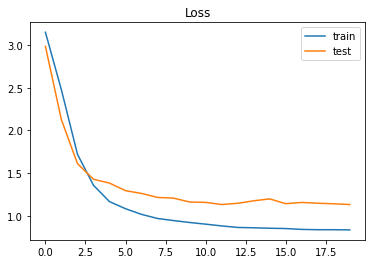

In [29]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

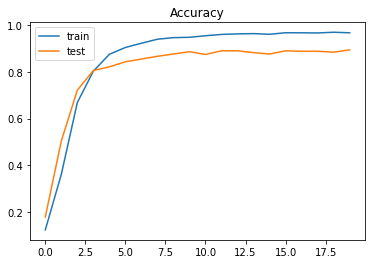

In [31]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

Function to generate flair which will be used in the application script

In [0]:
def generate_flair(title):
  title = [title]
  seq = tokenizer.texts_to_sequences(title)
  padded = pad_sequences(seq, maxlen = max_seq_length)
  pred = model.predict(padded)
  return list_classes[np.argmax(pred)]

Storing the model in a pickle file

In [0]:
import pickle
pickle.dump(model, open('lstm_model3.pkl','wb'))

Loading the model

In [0]:
model = pickle.load(open('lstm_model3.pkl','rb'))